In [1]:
import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import BaseModel
from hbmep.model import functional as F
from hbmep.model.utils import Site as site

from learn_posterior import LearnPosterior

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
dest = "/home/vishu/logs/visual-comparison.log"
logging.basicConfig(
    format=FORMAT,
    level=logging.INFO,
    handlers=[
        logging.FileHandler(dest, mode="w"),
        logging.StreamHandler()
    ],
    force=True
)


In [2]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/config.toml"
config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "experiments", "sparse-subjects", "learn-posterior")
config.FEATURES = ["participant", "intervention"]
config.RESPONSE = ["PKPK_APB"]
config.MCMC_PARAMS["num_warmup"] = 10000
config.MCMC_PARAMS["num_samples"] = 4000

""" Load learn posterior """
src = "/home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/inference.pkl"
with open(src, "rb") as g:
    model, _, posterior_samples_learnt = pickle.load(g)

src = "/home/vishu/data/hbmep-processed/human/tms/proc_2023-11-28.csv"
df = pd.read_csv(src)
df[model.features[1]] = 0
df, _ = model.load(df=df)


2023-12-14 14:19:40,501 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior
2023-12-14 14:19:40,502 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior
2023-12-14 14:19:40,503 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2023-12-14 14:19:40,504 - hbmep.dataset.core - WARNING - Total missing observations: 0
2023-12-14 14:19:40,504 - hbmep.dataset.core - INFO - Processing data ...
2023-12-14 14:19:40,505 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
""" Simulate Existing Participants """
posterior_samples_learnt["outlier_prob"] = \
        0 * posterior_samples_learnt["outlier_prob"] # Turn off outlier distribution
ppd_existing_participants = \
    model.predict(df=df, posterior_samples=posterior_samples_learnt)

""" Shuffle draws """
keys = jax.random.split(model.rng_key, num=3)
ind = jax.random.permutation(key=keys[0], x=jnp.arange(0, ppd_existing_participants[site.obs].shape[0], 1))
ppd_existing_participants = {
    k: v[ind, ...] for k, v in ppd_existing_participants.items()
}


2023-12-14 14:19:50,247 - hbmep.utils.utils - INFO - func:predict took: 9.74 sec


In [10]:
# """ Plot draws for existing participants """
# n_draws_to_plot = 3
# temp_df = df.copy()
# temp_ppd = {
#     k: v.swapaxes(0, -1) for k, v in ppd_existing_participants.items()
# }
# temp_obs = temp_ppd[site.obs]
# logger.info(f"temp_obs: {temp_obs.shape}")
# logger.info(f"temp_obs: {type(temp_obs)}")

# response = model.response
# response += [f"Draw {i + 1}" for i in range(n_draws_to_plot)]
# temp_df[response[1:]] = temp_obs[0, ..., :n_draws_to_plot]

# dest = os.path.join(model.build_dir, "visual_comparison_existing_subjects.pdf")
# model.plot(
#     df=temp_df,
#     response=response,
#     response_colors = plt.cm.rainbow(np.linspace(0, 1, n_draws_to_plot + 1)),
#     destination_path=dest
# )


2023-12-14 14:32:27,834 - __main__ - INFO - temp_obs: (1, 1415, 16000)
2023-12-14 14:32:27,835 - __main__ - INFO - temp_obs: <class 'numpy.ndarray'>
2023-12-14 14:32:27,838 - hbmep.model.baseline - INFO - Rendering ...
2023-12-14 14:32:31,628 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/visual_comparison_existing_subjects.pdf
2023-12-14 14:32:31,628 - hbmep.utils.utils - INFO - func:plot took: 3.79 sec


In [5]:
""" Create template dataframe for simulating new participants """
N_NEW_SUBJECTS_TO_SIMULATE = 30
simulation_df = \
    pd.DataFrame(np.arange(0, N_NEW_SUBJECTS_TO_SIMULATE, 1), columns=[model.features[0]]) \
    .merge(
        pd.DataFrame(np.arange(0, 1, 1), columns=model.features[1:]),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 90], columns=[model.intensity]),
        how="cross"
    )
simulation_df = model.make_prediction_dataset(
    df=simulation_df,
    min_intensity=0,
    max_intensity=100,
    num=60
)

""" Simulate new participants data """
priors = {
    "global-priors": [
        "b_scale_global_scale",
        "v_scale_global_scale",
        "L_scale_global_scale",
        "ell_scale_global_scale",
        "H_scale_global_scale",
        "g_1_scale_global_scale",
        "g_2_scale_global_scale"
    ],
    "hyper-priors": [
        "b_scale_raw",
        "v_scale_raw",
        "L_scale_raw",
        "ell_scale_raw",
        "H_scale_raw",
        "g_1_scale_raw",
        "g_2_scale_raw",

        "b_scale",
        "v_scale",
        "L_scale",
        "ell_scale",
        "H_scale",
        "g_1_scale",
        "g_2_scale"
    ],
    "baseline-priors": [
        "a_fixed_mean",
        "a_fixed_scale"
    ]
}
sites_to_use_for_simulation = ["outlier_prob"]
sites_to_use_for_simulation += priors["global-priors"]
sites_to_use_for_simulation += priors["hyper-priors"]
sites_to_use_for_simulation += priors["baseline-priors"]
posterior_samples_learnt = {    # Freeze priors
    k: v for k, v in posterior_samples_learnt.items() if k in sites_to_use_for_simulation
}
posterior_samples_learnt["outlier_prob"] = \
    0 * posterior_samples_learnt["outlier_prob"] # Turn off outlier distribution
ppd_new_participants = \
    model.predict(df=simulation_df, posterior_samples=posterior_samples_learnt)

""" Filter valid draws """
a = ppd_new_participants[site.a]
b = ppd_new_participants[site.b]
H = ppd_new_participants[site.H]
ind = ((a > 10) & (a < 70) & (b > .05) & (H > .1)).all(axis=(1, 2, 3))
n_valid_draws = ind.sum()
logger.info(f"No. of valid simulations: {n_valid_draws}")
ppd_new_participants = {
    k: v[ind, ...] for k, v in ppd_new_participants.items()
}

""" Shuffle draws """
ind = jax.random.permutation(key=keys[1], x=jnp.arange(0, ppd_new_participants[site.obs].shape[0], 1))
ppd_new_participants = {
    k: v[ind, ...] for k, v in ppd_new_participants.items()
}

""" Positive response constraint """
sim_obs = ppd_new_participants[site.obs]
ind = (sim_obs > 0).all(axis=(1, 2))
logger.info(f"valid_draws: {ind.shape}")
logger.info(f"No. of valid simulations after accounting for positive response: {ind.sum()}")
ppd_new_participants = {
    k: v[ind, ...] for k, v in ppd_new_participants.items()
}


2023-12-14 14:19:50,672 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-12-14 14:20:05,517 - hbmep.utils.utils - INFO - func:predict took: 14.82 sec
2023-12-14 14:20:05,519 - __main__ - INFO - No. of valid simulations: 88
2023-12-14 14:20:05,596 - __main__ - INFO - valid_draws: (88,)
2023-12-14 14:20:05,597 - __main__ - INFO - No. of valid simulations after accounting for positive response: 87


In [ ]:
# """ Plot draws for new participants """
# n_draws_to_plot = 3
# temp_df = simulation_df.copy()
# temp_ppd = {
#     k: v.swapaxes(0, -1) for k, v in ppd_new_participants.items()
# }
# temp_obs = temp_ppd[site.obs]
# logger.info(f"temp_obs: {temp_obs.shape}")
# logger.info(f"temp_obs: {type(temp_obs)}")

# response = [f"Draw {i + 1}" for i in range(n_draws_to_plot)]
# temp_df[response] = temp_obs[0, ..., :n_draws_to_plot]

# dest = os.path.join(model.build_dir, "visual_comparison_new_participants.pdf")
# model.render_recruitment_curves(
#     df=temp_df,
#     response=response,
#     response_colors = plt.cm.rainbow(np.linspace(0, 1, n_draws_to_plot)),
#     prediction_df=temp_df,
#     posterior_predictive=temp_ppd,
#     posterior_samples=temp_ppd,
#     destination_path=dest
# )


2023-12-14 14:47:50,641 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/visual_comparison.png


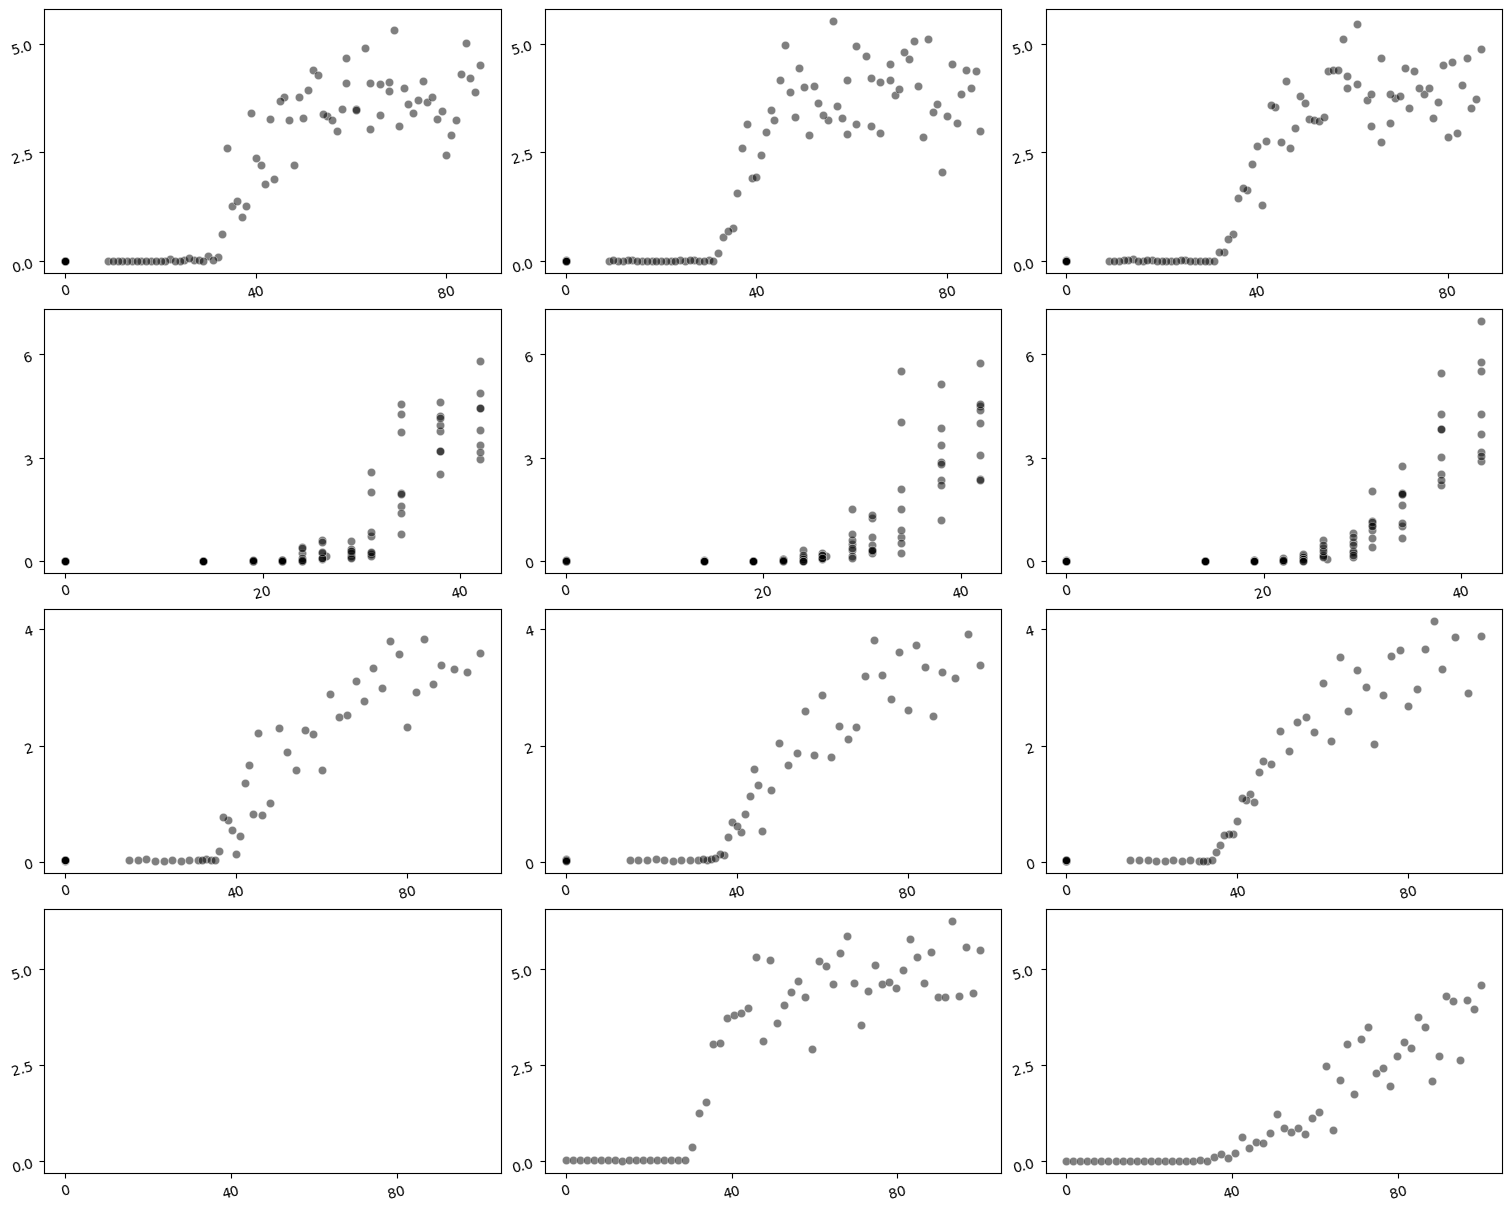

In [31]:
nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3), squeeze=False, constrained_layout=True, sharex="row", sharey="row")

draws_dict = {
    (6, 0): [0, 2],
    (9, 0): [0, 4],
    (10, 0): [1, 7]
}
counter = 0
for c in draws_dict.keys():
    ind = df[model.features].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True)

    ax = axes[counter, 0]
    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[0]], ax=ax, color="black", alpha=.5)

    cc = 0
    for draw in draws_dict[c]:
        ax = axes[counter, cc + 1]
        sns.scatterplot(x=temp_df[model.intensity], y=ppd_existing_participants[site.obs][draw, ind, 0], ax=ax, color="black", alpha=.5)
        cc += 1

    counter += 1

cc = 0
for c in [(9, 0, 0), (29, 0, 2)]:
    ind = simulation_df[model.features].apply(tuple, axis=1).isin([(c[0], c[1])])
    temp_df = simulation_df[ind].reset_index(drop=True)
    ax = axes[3, cc + 1]
    sns.scatterplot(x=temp_df[model.intensity], y=ppd_new_participants[site.obs][c[-1], ind, 0], ax=ax, color="black", alpha=.5)
    cc += 1

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

dest = os.path.join(model.build_dir, "visual_comparison.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "visual_comparison.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
